In [76]:
%matplotlib inline

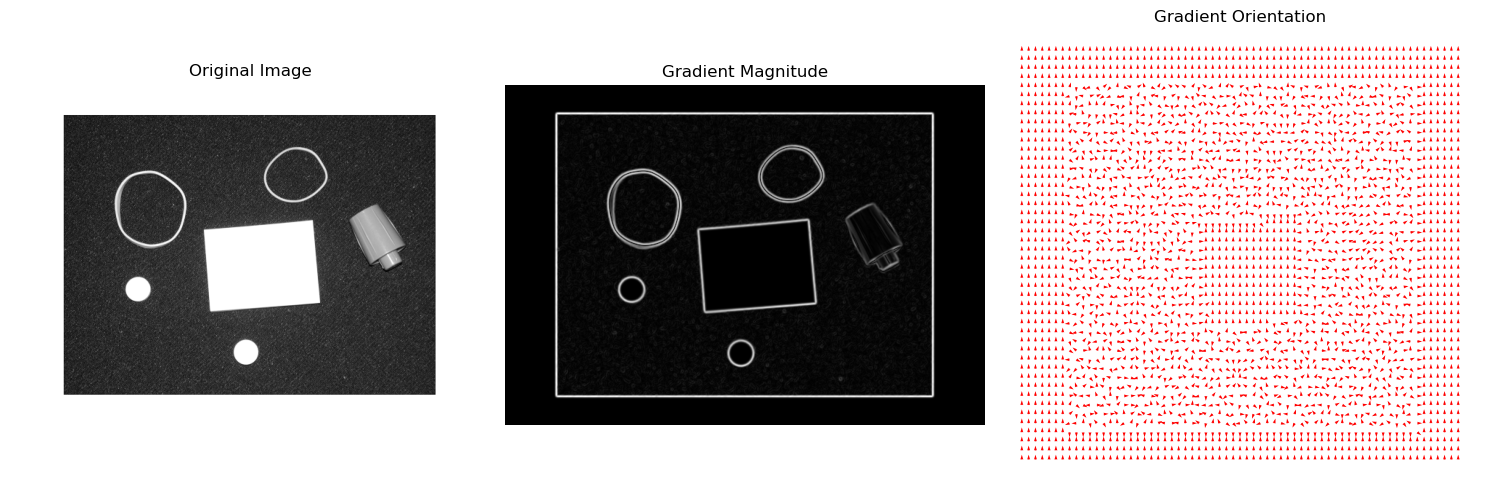

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def generate_gaussian_kernel(kernel_size, sigma):

    kernel = np.zeros((kernel_size, kernel_size))
    half_size = kernel_size // 2
    sum_val = 0 

    
    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i - half_size
            y = j - half_size
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
            sum_val += kernel[i, j]

    # Normalize the kernel so that the sum is 1
    kernel /= sum_val
    return kernel

def custom_convolution(image, kernel):

    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape

    # output array for the convolved result
    convolved_image = np.zeros((image_height - kernel_height + 1, image_width - kernel_width + 1))

    # convolution
    for i in range(convolved_image.shape[0]):
        for j in range(convolved_image.shape[1]):
            region = image[i:i + kernel_height, j:j + kernel_width]
            convolved_image[i, j] = np.sum(region * kernel)
    
    return convolved_image

def gradient_edge_detection(image, sigma):

    # Generate Gaussian kernel
    kernel_size = int(6 * sigma) + 1  # Ensure odd kernel size
    gaussian_kernel = generate_gaussian_kernel(kernel_size, sigma)
    
    # Smooth the image
    smoothed_image = custom_convolution(image, gaussian_kernel)
    
    # Create gradient filters for x and y
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # Sobel filter for x-derivative
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])  # Sobel filter for y-derivative
    
    # Apply convolution with derivative filters
    grad_x = custom_convolution(smoothed_image, sobel_x)
    grad_y = custom_convolution(smoothed_image, sobel_y)
    
    # Compute gradient magnitude and orientation
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    orientation = np.arctan2(grad_y, grad_x)
    
    return magnitude, orientation

def display_results(image, magnitude, orientation):

    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Gradient Magnitude
    plt.subplot(1, 3, 2)
    plt.imshow(magnitude, cmap='gray')
    plt.title('Gradient Magnitude')
    plt.axis('off')

    #Orientation 
    plt.subplot(1, 3, 3)
    step = 10
    Y, X = np.mgrid[step//2:magnitude.shape[0]:step, step//2:magnitude.shape[1]:step]
    U = np.cos(orientation[Y, X])
    V = np.sin(orientation[Y, X])
    plt.quiver(X, Y, U, V, color='red')
    plt.title('Gradient Orientation')
    plt.gca().invert_yaxis()
    plt.axis('off')

    plt.tight_layout()
    plt.show()


image_path = r'C:\Users\Shishir yadav\Desktop\Folders\Fall24\comp v\Project2\1.png'
image = np.array(Image.open(image_path).convert('L'), dtype=np.float32) / 255.0


sigma_value = 1.0


magnitude, orientation = gradient_edge_detection(image, sigma_value)


display_results(image, magnitude, orientation)


Click to select seed points. Press 'q' to finish selection.
Seed point selected at: x=493, y=170
Seed point selected at: x=400, y=88
Seed point selected at: x=195, y=118
Seed point selected at: x=335, y=194
Seed point selected at: x=329, y=349
Seed point selected at: x=172, y=264
Tracing boundary starting from seed point: (493, 170)
Tracing boundary starting from seed point: (400, 88)
Tracing boundary starting from seed point: (195, 118)
Tracing boundary starting from seed point: (335, 194)
Tracing boundary starting from seed point: (329, 349)
Tracing boundary starting from seed point: (172, 264)


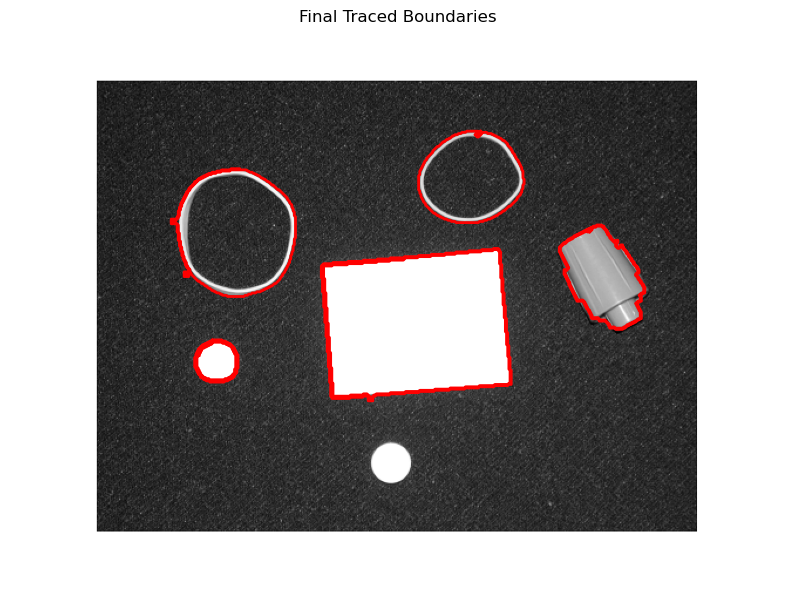

In [139]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def perform_edge_detection(image):

    edges = cv2.Canny(image, 50, 150)
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    return edges

def get_seed_points(edge_image):
    seed_points = []

    def on_mouse_click(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            seed_points.append((x, y))
            print(f"Seed point selected at: x={x}, y={y}")
            cv2.circle(edge_image_display, (x, y), 3, (255, 0, 0), -1)
            cv2.imshow('Edge Image', edge_image_display)
    
    edge_image_display = edge_image.copy()  # Copy for displaying selection feedback
    cv2.namedWindow('Edge Image')
    cv2.setMouseCallback('Edge Image', on_mouse_click)

    print("Click to select seed points. Press 'q' to finish selection.")
    
    while True:
        cv2.imshow('Edge Image', edge_image_display)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):  # Exit on 'q' key press
            break

    cv2.destroyAllWindows()

    if seed_points:
        return seed_points
    else:
        print("No seed points selected. Exiting.")
        exit()

def manual_boundary_tracing(edge_image, start_point):

    height, width = edge_image.shape
    traced_boundary = []
    visited = np.zeros_like(edge_image, dtype=bool)

    directions = [(-1,  0),  # N
                  (-1,  1),  # NE
                  ( 0,  1),  # E
                  ( 1,  1),  # SE
                  ( 1,  0),  # S
                  ( 1, -1),  # SW
                  ( 0, -1),  # W
                  (-1, -1)]  # NW

    current_point = start_point
    traced_boundary.append(current_point)
    visited[current_point[1], current_point[0]] = True

    backtrack_direction = 0  

    while True:
        found_next = False

        for i in range(8):
            idx = (backtrack_direction + i) % 8
            dx, dy = directions[idx]
            x, y = current_point[0] + dx, current_point[1] + dy

            if 0 <= x < width and 0 <= y < height:
                if edge_image[y, x] != 0 and not visited[y, x]:
                    current_point = (x, y)
                    traced_boundary.append(current_point)
                    visited[y, x] = True
                    backtrack_direction = (idx + 5) % 8
                    found_next = True
                    break

        if not found_next or current_point == start_point or len(traced_boundary) > 10000:
            break

    return traced_boundary

def plot_traced_boundaries(original_image, all_boundaries):

    plt.figure(figsize=(10, 8))
    plt.imshow(original_image, cmap='gray')
    
    for boundary_points in all_boundaries:
        if boundary_points:
            x_coords, y_coords = zip(*boundary_points)
            plt.plot(x_coords, y_coords, 'r-', linewidth=2)
        else:
            print("No boundary points to display.")
    
    plt.title('Final Traced Boundaries')
    plt.axis('off')
    plt.show()

def main():
  
    image_path = r'C:\Users\Shishir yadav\Desktop\Folders\Fall24\comp v\Project2\1.png'
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error loading image.")
        return

   
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)


    edges = perform_edge_detection(binary_image)

  
    seed_points = get_seed_points(edges)

  
    all_boundaries = []
    for seed_point in seed_points:
        print(f"Tracing boundary starting from seed point: {seed_point}")
        boundary = manual_boundary_tracing(edges, seed_point)
        all_boundaries.append(boundary)

    
    plot_traced_boundaries(image, all_boundaries)

if __name__ == "__main__":
    main()


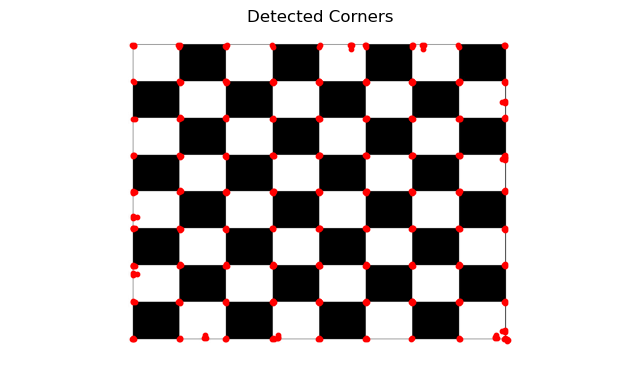

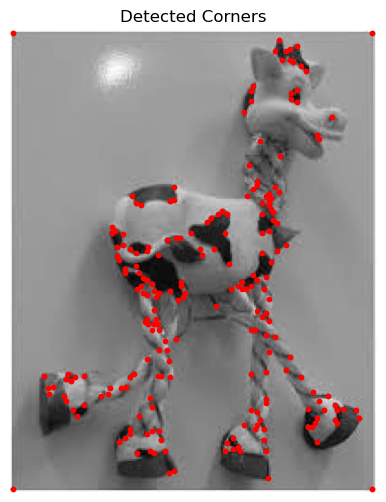

Corner detection completed.


In [120]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def load_image(image_path):
    img = Image.open(image_path).convert('L')
    img = np.array(img, dtype=np.float32)
    return img

def compute_gradients(img):
    
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[ 1,  2,  1],
                        [ 0,  0,  0],
                        [-1, -2, -1]], dtype=np.float32)
   
    grad_x = convolve(img, sobel_x)
    grad_y = convolve(img, sobel_y)
    return grad_x, grad_y

def gaussian_kernel(size, sigma=1.0):
    kernel = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    sum_total = 0.0
    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            kernel[i, j] = np.exp(-(x**2 + y**2)/(2 * sigma**2))
            sum_total += kernel[i, j]
    kernel = kernel / sum_total
    return kernel

def convolve(image, kernel):
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_h = kernel_height // 2
    pad_w = kernel_width // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    output = np.zeros_like(image, dtype=np.float32)
    kernel_flipped = np.flipud(np.fliplr(kernel))
    for y in range(img_height):
        for x in range(img_width):
            region = padded_image[y:y+kernel_height, x:x+kernel_width]
            output[y, x] = np.sum(region * kernel_flipped)
    return output

def harris_corner_detector(img, sigma=1.0, k=0.04, window_size=3):
    grad_x, grad_y = compute_gradients(img)
    Ixx = grad_x ** 2
    Ixy = grad_x * grad_y
    Iyy = grad_y ** 2
    size = window_size
    gaussian = gaussian_kernel(size, sigma)
    Sxx = convolve(Ixx, gaussian)
    Sxy = convolve(Ixy, gaussian)
    Syy = convolve(Iyy, gaussian)
    det_M = (Sxx * Syy) - (Sxy ** 2)
    trace_M = Sxx + Syy
    R = det_M - k * (trace_M ** 2)
    return R

def find_local_maxima(R, threshold=0.01, window_size=3):
    corners = []
    R_max = np.max(R)
    threshold_value = threshold * R_max
    offset = window_size // 2
    height, width = R.shape
    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            if R[y, x] > threshold_value:
                local_window = R[y - offset:y + offset + 1, x - offset:x + offset + 1]
                if R[y, x] == np.max(local_window):
                    corners.append((y, x))
    return corners

def display_corners(img, corners):
    plt.figure(figsize=(8,6))
    plt.imshow(img, cmap='gray')
    if corners:
        y_coords, x_coords = zip(*corners)
        plt.scatter(x_coords, y_coords, color='red', s=10)
    plt.title("Detected Corners")
    plt.axis('off')
    plt.show() 

def main():
    # Load images
    image_path_1 = r'C:\Users\Shishir yadav\Desktop\Folders\Fall24\comp v\Project2\2-1.jpg'
    image_path_2 = r'C:\Users\Shishir yadav\Desktop\Folders\Fall24\comp v\Project2\2-2.jpg'
    img1 = load_image(image_path_1)
    img2 = load_image(image_path_2)
    # Apply Harris corner detection
    R1 = harris_corner_detector(img1, sigma=1.5, k=0.04, window_size=3)
    R2 = harris_corner_detector(img2, sigma=1.5, k=0.04, window_size=3)
    # Find local maxima
    corners1 = find_local_maxima(R1, threshold=0.01, window_size=3)
    corners2 = find_local_maxima(R2, threshold=0.01, window_size=3)
    # Display detected corners
    display_corners(img1, corners1)
    display_corners(img2, corners2)
    print("Corner detection completed.")

if __name__ == "__main__":
    main()


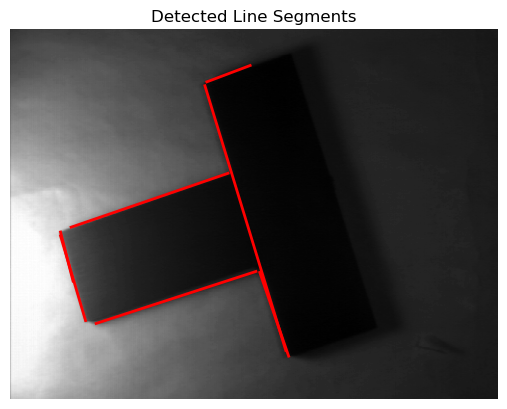

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, feature

#Define the Hough Transform Function
def perform_hough_transform(edge_img, theta_res=1, rho_res=1):

    rows, cols = edge_img.shape
    
    # Define theta and rho ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, theta_res))
    diag_len = int(np.ceil(np.sqrt(rows**2 + cols**2)))  
    rhos = np.arange(-diag_len, diag_len, rho_res) 
    
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=int)
    
    edge_points = np.argwhere(edge_img)
    
    for y, x in edge_points:
        for theta_idx, theta in enumerate(thetas):
            rho = int((x * np.cos(theta)) + (y * np.sin(theta)))
            rho_idx = np.argmin(np.abs(rhos - rho))
            accumulator[rho_idx, theta_idx] += 1
    
    return accumulator, thetas, rhos

#Detect Lines from the Hough Accumulator
def extract_lines_from_accumulator(accumulator, thetas, rhos, num_lines=10, threshold=30):
    lines = []
    
    for _ in range(num_lines):
        max_idx = np.argmax(accumulator)
        rho_idx, theta_idx = np.unravel_index(max_idx, accumulator.shape)
        
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        
        if accumulator[rho_idx, theta_idx] > threshold:
            lines.append((rho, theta))
        
        accumulator[max(0, rho_idx-8):min(accumulator.shape[0], rho_idx+8),
                    max(0, theta_idx-8):min(accumulator.shape[1], theta_idx+8)] = 0
    
    return lines

#Extract Line Segments from Detected Lines
def find_line_segments(image, edges, lines, min_length=15):
    segments = []
    height, width = image.shape
    
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 3000 * (-b))  
        y1 = int(y0 + 3000 * (a))   
        x2 = int(x0 - 3000 * (-b))  
        y2 = int(y0 - 3000 * (a))  
        
        mask = np.zeros_like(image, dtype=np.uint8)
        rr, cc = np.linspace(y1, y2, num=3000, dtype=int), np.linspace(x1, x2, num=3000, dtype=int)
        mask[rr.clip(0, height-1), cc.clip(0, width-1)] = 1
        
        intersections = np.logical_and(mask, edges)
        points = np.argwhere(intersections)
        
        if len(points) >= 2:
            dist = np.linalg.norm(points[-1] - points[0])
            if dist >= min_length:
                segments.append((tuple(points[0][::-1]), tuple(points[-1][::-1])))
    
    return segments

#Ploting Detected Line Segments
def plot_line_segments(image, segments):
    plt.imshow(image, cmap='gray')
    
    for (x1, y1), (x2, y2) in segments:
        plt.plot([x1, x2], [y1, y2], 'r-', linewidth=2)
    
    plt.title("Detected Line Segments")
    plt.axis('off')
    plt.show()

#Main Function to Run the Extended Hough Transform
def hough_transform_pipeline(image_path, sigma=2.0, num_lines=10, min_length=15):
    image = io.imread(image_path, as_gray=True)
    
    edges = feature.canny(image, sigma=sigma)
    accumulator, thetas, rhos = perform_hough_transform(edges)
    lines = extract_lines_from_accumulator(accumulator, thetas, rhos, num_lines)
    line_segments = find_line_segments(image, edges, lines, min_length)
    plot_line_segments(image, line_segments)


image_path = r'C:\Users\Shishir yadav\Desktop\Folders\Fall24\comp v\Project2\3.png'
hough_transform_pipeline(image_path, sigma=2.0, num_lines=10, min_length=15)


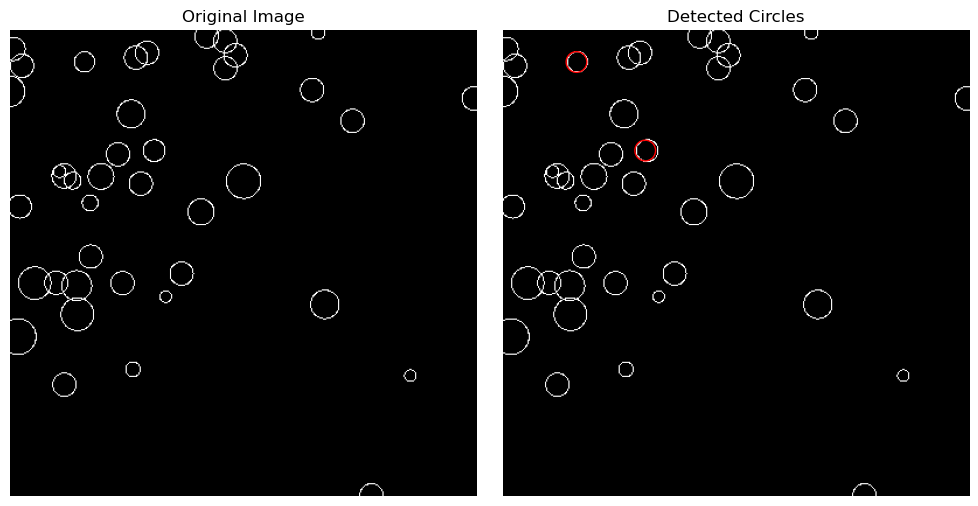

Detected circle centers:
Circle 1: center at (63, 27)
Circle 2: center at (122, 103)


In [118]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio

def train_circle_detector(binary_image, center_point, boundary_points):
   
    # Computing radius based on boundary points
    radius_values = [np.sqrt((x - center_point[0])**2 + (y - center_point[1])**2) for x, y in boundary_points]
    estimated_radius = np.mean(radius_values)
    
    # Creating a circle template based on the calculated radius
    angles = np.linspace(0, 2 * np.pi, 100)
    x_circle = estimated_radius * np.cos(angles)
    y_circle = estimated_radius * np.sin(angles)
    
    # Store results in a dictionary
    detector_data = {
        'radius': estimated_radius,
        'x_template': x_circle,
        'y_template': y_circle
    }
    
    return detector_data

def detect_circles_in_image(new_binary_image, trained_data):

    radius = trained_data['radius']
    x_template = trained_data['x_template']
    y_template = trained_data['y_template']
    
    img_height, img_width = new_binary_image.shape
    accumulator_array = np.zeros((img_height, img_width))
    
    # Identifing edge pixels in the binary image
    edge_pixels = np.argwhere(new_binary_image > 0)
    for y_pixel, x_pixel in edge_pixels:
        for dx, dy in zip(x_template, y_template):
            center_x = int(x_pixel - dx)
            center_y = int(y_pixel - dy)
            if 0 <= center_x < img_width and 0 <= center_y < img_height:
                accumulator_array[center_y, center_x] += 1
    
    # Find the top 2 circle centers from the accumulator
    detected_centers = []
    for _ in range(2):
        max_index = np.unravel_index(np.argmax(accumulator_array), accumulator_array.shape)
        detected_centers.append((max_index[1], max_index[0]))  
        y, x = max_index
        accumulator_array[max(0, y-10):min(img_height, y+11), max(0, x-10):min(img_width, x+11)] = 0
    
    return detected_centers

def visualize_detection(original_image, circle_centers, radius):
    plt.figure(figsize=(10, 5))
    
    # original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Detected circles
    plt.subplot(1, 2, 2)
    plt.imshow(original_image, cmap='gray')
    plt.title('Detected Circles')
    plt.axis('off')
    
    #Circles on the image
    for center in circle_centers:
        circle_outline = plt.Circle(center, radius, color='r', fill=False)
        plt.gca().add_artist(circle_outline)
    
    plt.tight_layout()
    plt.show()

train_data = sio.loadmat(r'C:\Users\Shishir yadav\Desktop\Folders\Fall24\comp v\Project2\train.mat')
circle_center = (train_data['c'][0][0], train_data['c'][0][1])  # Use center point from mat
boundary_coords = [(x[0], x[1]) for x in train_data['ptlist']]  # Convert boundary points

train_image_file = r'C:\Users\Shishir yadav\Desktop\Folders\Fall24\comp v\Project2\train.png'  # Path to your training image
train_img = np.array(Image.open(train_image_file).convert('L'))
train_binary_img = (train_img > 128).astype(np.uint8)

trained_circle_data = train_circle_detector(train_binary_img, circle_center, boundary_coords)

test_image_file = r'C:\Users\Shishir yadav\Desktop\Folders\Fall24\comp v\Project2\test.png'  # Path to your test image
test_img = np.array(Image.open(test_image_file).convert('L'))
test_binary_img = (test_img > 128).astype(np.uint8)

circle_centers = detect_circles_in_image(test_binary_img, trained_circle_data)

visualize_detection(test_img, circle_centers, trained_circle_data['radius'])

print("Detected circle centers:")
for i, center in enumerate(circle_centers, 1):
    print(f"Circle {i}: center at {center}")
